# Fake News Detection

Text classification using multilayer perceptrons
___

Fake news is real problem, and a big one too. One of the many downsides of social media is the constant flow of misinformation that pervades the networks. Even the term itself has been overused and obscured to blur the distinction between fact and fiction. As the world becomes more connected, it seems many are choosing to be more connected primarily with others who share their same views, creating an ideal environment for untruths to go unchecked. But fake news isn't just a political issue. Covid-19 brought with it a whole new arena of conspiracy theories and bogus medical advice. Detecting fake news is essential to stopping the spread of misinformation.   

## Data
The data consists of news articles and titles along with date published and subject. It's divided into 2 separate files, one of real news articles and one of fake news articles. 
### Acknowledgements  
Ahmed H, Traore I, Saad S. “Detecting opinion spams and fake news using text classification”, Journal of Security and Privacy, Volume 1, Issue 1, Wiley, January/February 2018.
Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138).
___

### Environment 
The model was trained on AWS EC2 using the AMI ["Deep Learning Notebook (Python 3, Tensorflow 2, Pytorch 1.3)"](https://aws.amazon.com/marketplace/pp/B07MH31FT7?ref_=srh_res_product_title) This AMI has a quick and easy setup to run notebooks on an instance that has automatic support of GPUs.  

##### Run the cell below to add necessary packages which are not preinstalled to the environment. 

In [1]:
# Run this to install packages in deep learning AMI
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install sklearn
!pip install wordcloud
!pip install boto3

## Import packages and load data

In [1]:
# Import packages
import numpy as np
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
import boto3
import s3fs
import re 
nltk.download('stopwords')

%matplotlib inline

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


###### The following 3 cells copy the data from s3 and read it into dataframes. This is used when working in an EC2 instance for model training. 

In [31]:
! aws s3 cp s3://lp-s3-bucket/Fake.csv ./data

download: s3://lp-s3-bucket/Fake.csv to data/Fake.csv             


In [32]:
! aws s3 cp s3://lp-s3-bucket/True.csv ./data

download: s3://lp-s3-bucket/True.csv to data/True.csv            


In [2]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

###### The following 3 cells reads in the data from a local directory 

In [2]:
file_path = %pwd

In [3]:
files = []
for dirname, _, filenames in os.walk(file_path+"\data"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
            files.append(os.path.join(dirname, filename))

C:\Users\Loren\fake news\data\Fake.csv\Fake.csv
C:\Users\Loren\fake news\data\True.csv\True.csv


In [4]:
fake = pd.read_csv(files[0])
true = pd.read_csv(files[1])

___
## Exploratory Data Analysis

The data is in two seperate dataframes. So we'll take a peak at each one then combine them.

In [4]:
print(fake.shape)
fake.head()

(23481, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
print(true.shape)
true.head()

(21417, 4)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


##### Without reading every article we want to explore the data a bit to prevent any potential data leakage. Let's take a look at a couple of the articles to get an idea of what they contain.

In [25]:
# print real article example
true.text[106]

'WASHINGTON (Reuters) - A lawyer nominated by President Donald Trump to serve as a federal judge withdrew from consideration on Monday after video of his Senate confirmation hearing showing him unable to provide answers to rudimentary legal questions went viral last week. Trump accepted Matthew Petersen’s offer to withdraw his nomination as a district court judge in Washington, a White House official said. Petersen, a Republican member of the Federal Election Commission, became the latest of Trump’s judicial nominations to fail as the president seeks to win confirmation of judges who will make the federal judiciary more conservative. “Just because you’ve seen ‘My Cousin Vinny’ doesn’t qualify you to be a federal judge,” Republican Senator John Kennedy, who grilled Petersen during his Dec. 13 confirmation hearing, told WWL-TV, referring to the 1992 comedy film about a novice lawyer. Kennedy, who has been critical of some of Trump’s judicial nominees, asked several basic legal questions 

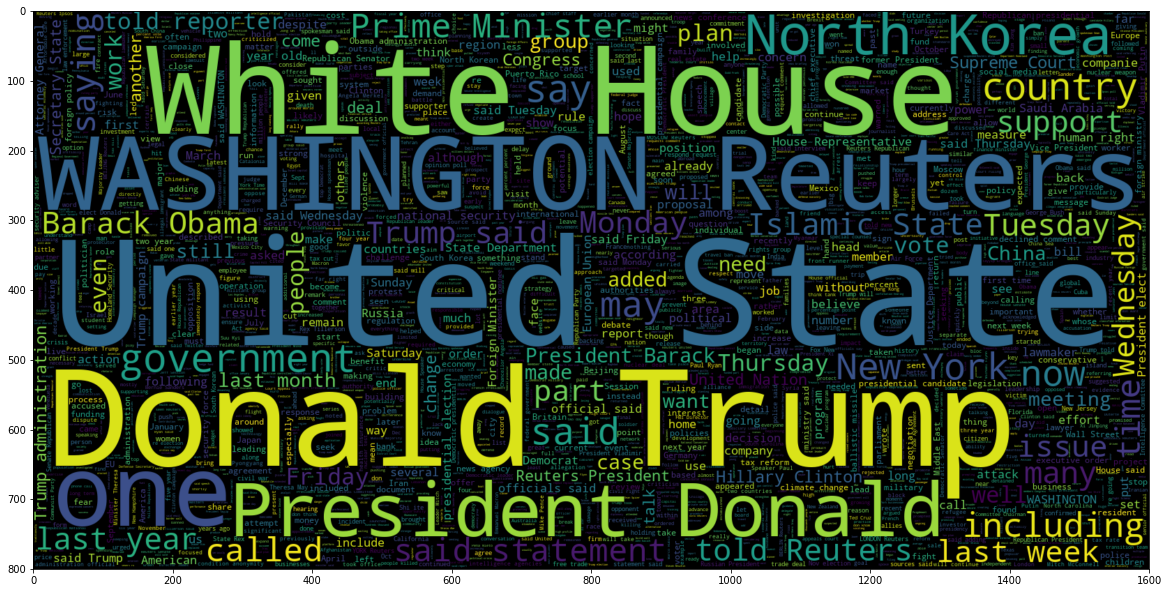

In [33]:
# plot a wordcloud of the real articles to get an idea of the common words
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2500 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(true.text))
plt.imshow(wc , interpolation = 'bilinear')

In [24]:
# print fake article example
fake.text[103]

'In the late 1970 s, Alabama Senate Candidate Roy Moore (R- Of Course) would have been in his early 30 s. However, he liked little girls   literally. A bombshell report in the Washington Post alleges that Moore, who was 32 in 1979, approached Leigh Corfman in a courthouse. Corfman was 14 at the time. Moore picked the little girl up near her home, drove her to his home in the woods, and proceeded to molest her, according to the story. Now, this is the man who is running for the United States Senate. The thing is, though, Moore s political career should have been over and done with decades ago.You see, according to people who worked with Roy Moore at the time, it was, quote,  common knowledge  that he liked dating high schoolers. Moore s former colleague Theresa Jones, who was a Deputy District Attorney with Moore at the time, says of the situation: It was common knowledge that Roy dated high school girls, everyone we knew thought it was weird We wondered why someone his age would hang o

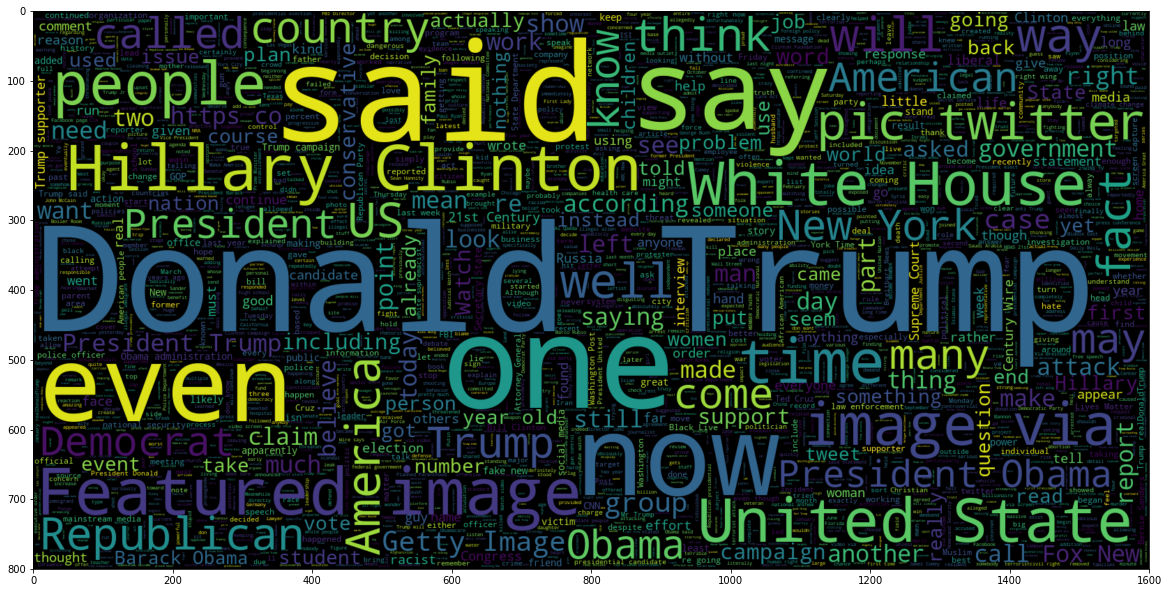

In [34]:
# plot a wordcloud of the fake articles to get an idea of the common words
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2500 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(fake.text))
plt.imshow(wc , interpolation = 'bilinear')

##### From looking at the head of the two tables it seems like a lot of the real articles start with the word 'Reuters', where the fake articels don't. Let's see if this is true.

In [15]:
# count how many times 'reuters' occurs in real articles.
sum(true.text.str.contains('reuters', case=False, regex=True))

21378

In [16]:
# count how many times 'reuters' occurs in fake articles.
sum(fake.text.str.contains('reuters', case=False, regex=True))

322

##### Since this is so unbalanced it won't be included in the features to avoid data leakage. 
##### Now we'll combine the two tables.

In [3]:
# Create a label column before combining. This will be our target variable.
true['label'] = 1
fake['label'] = 0

In [4]:
# Lets combine the two into 1 table
df = pd.concat([true, fake])

In [5]:
# let's create word counts for the titles and text to check for potential data leakage
df['title_count'] = df['title'].apply(lambda x: len(x.split()))
df['text_count'] = df['text'].apply(lambda x: len(x.split()))

In [6]:
df.head()

,title,text,subject,date,label,title_count,text_count
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,10,749
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,9,624
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,10,457
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,9,376
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,11,852


In [7]:
df.shape

(44898, 7)

In [8]:
# check for any missing values
df.isna().sum()

title          0
text           0
subject        0
date           0
label          0
title_count    0
text_count     0
dtype: int64

In [13]:
#check to see how the text lengths compare
df.groupby('label')['text_count'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,23481.0,423.197905,408.388890,0.0,240.0,363.0,506.0,8135.0
1,21417.0,385.640099,274.006204,0.0,148.0,359.0,525.0,5172.0


##### The fake articles are 38 words longer on average.  Lets see how the two distributions stack up next to each other.

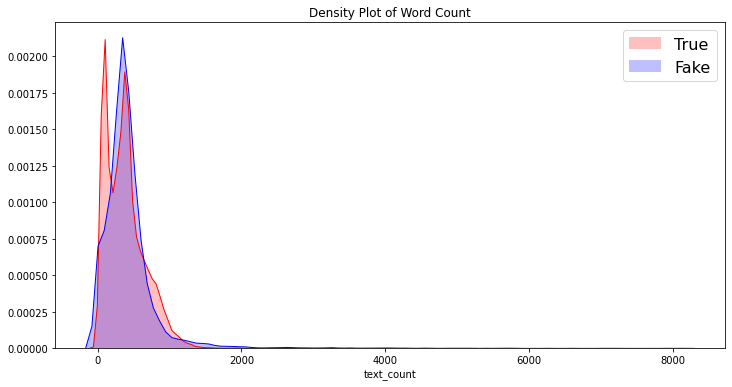

In [12]:
plt.figure(figsize=(12,6))

fake = df.loc[df.label == 0]
true = df.loc[df.label == 1]
sns.distplot(true['text_count'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1}, color="r")
sns.distplot(fake['text_count'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1}, color="b")

plt.legend(['True', 'Fake'], prop={'size': 16})
plt.title('Density Plot of Word Count')
plt.show()

##### The True word count has a surprising multimodal distribution but overall there is a lot of overlap.
##### Let's take a look at the subject variable.

In [13]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

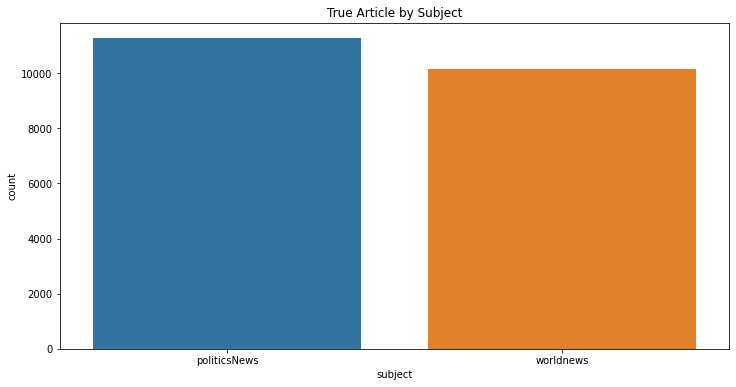

In [14]:
# Plot true articles by subject
plt.figure(figsize=(12,6))

sns.countplot(x='subject', data=true)

plt.title('True Article by Subject')
plt.show()

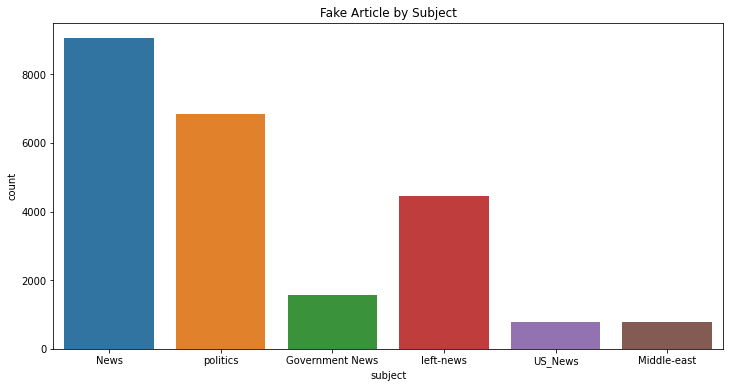

In [15]:
# Plot fake articles by subject
plt.figure(figsize=(12,6))

sns.countplot(x='subject', data=fake)

plt.title('Fake Article by Subject')
plt.show()

##### Here you can see there is a problem with the subject variable. Becuase the true and fake articles do not share any of the same subject labels, it cannot be included in the model.

___
## Feature Engineering
##### The text and title will be combined to make up the feature vector.

In [9]:
#Combine text and titles
df['text'] = df['text'] + " " + df['title']

In [10]:
# instantiate the stemmer tool and stopwords list
stemmer = PorterStemmer()
sw = stopwords.words('english')

In [11]:
# add the word 'reuers' to the stopwords
sw.append('reuters')

In [13]:
# Create text preprocessing function
def text_cleaner(text):
    # remove punctuation
    text = re.sub(r'[^\w\s]','',text) 
    # stem words
    word_list = []
    for i in text.split():
        if i.strip().lower() not in sw:
            word = stemmer.stem(i.strip())
            word_list.append(word)
    return " ".join(word_list)

In [14]:
# apply text cleaner to text
df.text = df.text.apply(text_cleaner)

In [15]:
# Create train, validation, and test groups for X & y
X = df["text"]
y = df["label"]
x, x_test, y, y_test = train_test_split(X, y,test_size=0.2,train_size=0.8)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25,train_size =0.75)

In [16]:
# Create feature vector using CountVectorizer
cv = CountVectorizer(ngram_range=(1,2))

cv_x_train = cv.fit_transform(x_train)

#transformed valid and test set
cv_x_valid =cv.transform(x_valid)
cv_x_test =cv.transform(x_test)


print('cv_train:',cv_x_train.shape)
print('cv_valid:',cv_x_valid.shape)
print('cv_test:',cv_x_test.shape)

cv_train: (26938, 2605878)
cv_valid: (8980, 2605878)
cv_test: (8980, 2605878)


## Build and train model

In [17]:
# Define model architecture
model = Sequential()
model.add(Dense(256, activation = 'relu' , input_dim = cv_x_train.shape[1]))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))

model.add(Dense(units = 1 , activation = 'sigmoid'))

In [18]:
# Compile model with binary crossentropy loss and 'adam' optimizer
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [19]:
# define model callbacks
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               patience=12,
                               factor=0.5,
                               verbose=1)
tensorboard = TensorBoard(log_dir="logs", write_graph=True, write_images=True)
early_stopper = EarlyStopping(monitor='val_loss',
                              mode='auto')
checkpoint = ModelCheckpoint('./models/model.h5')

In [20]:
# train model
training = model.fit(cv_x_train, y_train, 
                        validation_data=(cv_x_valid, y_valid),  
                        epochs=5, verbose=2) 
                        #callbacks=[lr_reducer, tensorboard])

Train on 26938 samples, validate on 8980 samples
Epoch 1/5
 - 3440s - loss: 0.0816 - accuracy: 0.9773 - val_loss: 0.0301 - val_accuracy: 0.9920
Epoch 2/5
 - 3426s - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0378 - val_accuracy: 0.9903
Epoch 3/5
 - 3453s - loss: 9.8351e-04 - accuracy: 0.9999 - val_loss: 0.0502 - val_accuracy: 0.9924
Epoch 4/5
 - 3417s - loss: 5.4657e-04 - accuracy: 0.9999 - val_loss: 0.0407 - val_accuracy: 0.9911
Epoch 5/5
 - 3418s - loss: 6.1980e-06 - accuracy: 1.0000 - val_loss: 0.0454 - val_accuracy: 0.9912


## Save / load model weights

In [21]:
# save model weights and architecture
import json
from keras.models import model_from_json, load_model


#Save Weights + Architecture
model.save_weights('model_weights.h5')
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [ ]:
#load weights if needed
#model.load_weights('model_weights.h5')

## Model evaluation

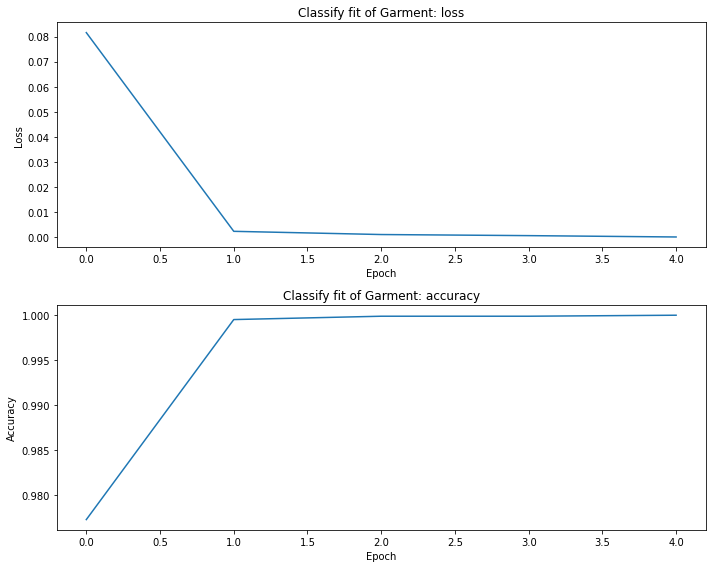

In [22]:
## Trained model analysis and evaluation
f, ax = plt.subplots(2,1, figsize=(10,8))
ax[0].plot(training.history['loss'])
ax[0].set_title('Classify fit of Garment: loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

# Accuracy
ax[1].plot(training.history['accuracy'])
ax[1].set_title('Classify fit of Garment: accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [23]:
# evaluate test group
score = model.evaluate(cv_x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

8980/8980 [==============================] - 285s 32ms/step
Test loss: 0.10148349083824212
Test accuracy: 0.9897550344467163


##### The test group accuracy is 99%

In [25]:
pred = model.predict(cv_x_test)

for i in range(len(pred)):
    if(pred[i] > 0.5):
        pred[i] = 1
    else:
        pred[i] = 0
        
accuracy_score(pred,y_test)

0.9897550111358575

In [26]:
# exacmine precision & recall
cv_report = classification_report(y_test,pred,target_names = ['0','1'])
print(cv_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4737
           1       0.99      0.99      0.99      4243

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [27]:
# print confusion matrix
cm_cv = confusion_matrix(y_test,pred)
cm_cv

array([[4686,   51],
       [  41, 4202]])

In [28]:
# plot confusion matrix
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

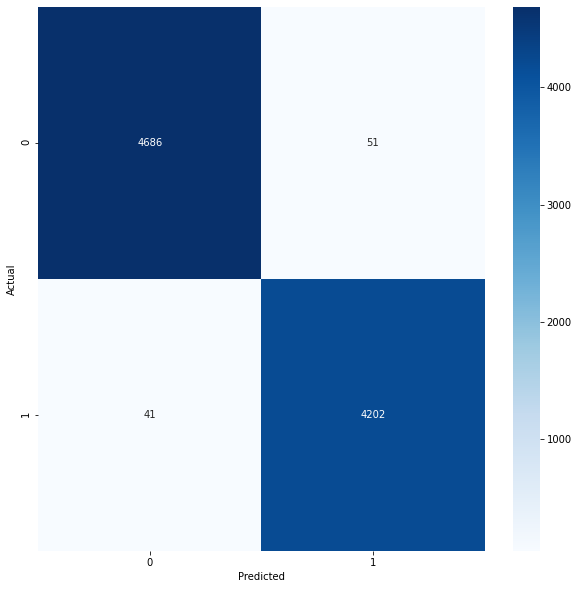

In [29]:
# plot confusion matrix
plt.figure(figsize = (10,10))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')